# 自回归条件异方差模型 - ARCH（p）
上一节介绍了ARMA、ARIMA等模型，这些模型一般都假设干扰项的方差为常数，然而很多情况下时间序列的波动有集聚性等特征，使得方差并不为常数。因此，如何刻画方差是十分有必要研究的。 本节介绍的ARCH、GARCH模型可以刻画出随时间变化的条件异方差。

波动率不可直接观测，但是在一些资产收益率时间序列中却普遍存在以下情况：
* 存在波动率聚集现象。 即波动率在一段时间上高，一段时间上低。
* 波动率以连续时间变化，很少发生跳跃
* 波动率不会发散到无穷，波动率往往是平稳的
* 波动率对价格大幅上升和大幅下降的反应是不同的，这个现象为杠杆效应

ARCH模型将当前一切可利用信息作为条件，并采用某种自回归形式来刻划方差的变异，对于一个时间序列而言，在不同时刻可利用的信息不同，而相应的条件方差也不同，利用ARCH模型，可以刻划出随时间而变异的条件方差。
##  ARCH模型思想
ARCH模型的基本思想是：
* 资产收益率$\{r_t\}$的扰动$\{\varepsilon_t\}$是序列不相关的，但不是独立的；
* $\{\varepsilon_t\}$的不独立性可以用其延迟值的简单二次函数来描述。

具体来说，一个$ARCH(m)$模型是假定：
$$ \large r_t=\mu+\varepsilon_t\\\large \sigma_t^2 = \omega + \alpha_1\varepsilon_{t-1}^2 + \cdots + \alpha_m \varepsilon_{t-m}^2 \\ \large \varepsilon_t = \sigma_te_t,e_t\sim N(0,1) \\ $$
$ \sigma_t^2$为条件异方差。可以看出，过去的扰动项${\{\varepsilon_{t-i}^2\}}^m_{i=1}$会影响方差项$\{\sigma_t^2\}$,也就是，大的扰动会倾向于紧接着出现另一个大的扰动，这很好的刻画了波动率聚集现象。
## ARCH模型建立
上面尽可能简单的介绍了ARCH的原理，下面主要介绍如何python实现。ARCH模型建立大致分为以下几步：
1. 通过检验数据的序列相关性建立一个均值方程，如有必要，对收益率序列建立一个计量经济模型（如ARMA）来消除任何线形依赖。
2. 对均值方程的残差进行ARCH效应检验
3. 如果具有ARCH效应，则建立波动率模型
4. 检验拟合的模型，如有必要则进行改进

In [1]:
# 库配置
%matplotlib notebook
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import matplotlib.pyplot as plt
import arch
plt.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体   
plt.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题

In [2]:
# tushare配置
import tushare as ts
ts.set_token('c5e635f32d3b7a8f1168362b0ca87988454155e835a5fd9ce5b43e38')
tp= ts.pro_api()
end='20170101'
start='20141216'
# 获取沪深300行情数据
get_px=lambda x:tp.index_daily(ts_code=x,start_date=start,end_date=end)['pct_change']
symbols={'sz':'000001.SH'}
data=pd.DataFrame(data={k:get_px(v) for k,v in symbols.items()})
data.index=pd.to_datetime(tp.index_daily(ts_code="399300.SZ",start_date=start,end_date=end)['trade_date'])
data.sort_index(ascending=True,inplace=True)
# log returns
lrets = data/100

<IPython.core.display.Javascript object>


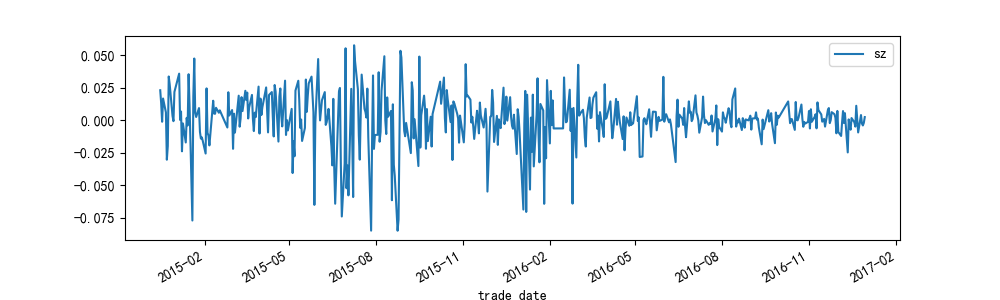

In [3]:
lrets.plot(figsize=(10,3))

In [4]:
# 时间序列特征分析绘图函数
def tsplot(y, lags=30, figsize=(8, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('时间序列分析')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05,title='自相关系数')
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05,title='偏自相关系数')
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)
        plt.tight_layout()
    return 

<IPython.core.display.Javascript object>


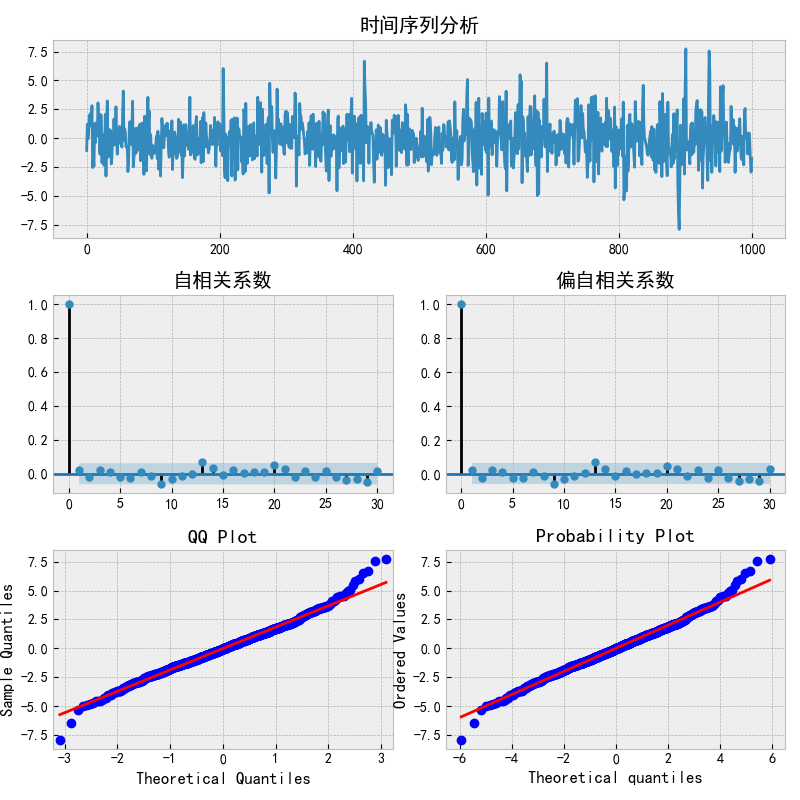

In [5]:
# 仿真ARCH(1)序列
np.random.seed(13)
a0 = 2
a1 = .5
y = w = np.random.normal(size=1000)
for t in range(len(y)):
    y[t] = w[t] * np.sqrt((a0 + a1*y[t-1]**2))
tsplot(y, lags=30)

上证指数收益率序列分析

首先检验平稳性，是否需要差分。 原假设$H_0$：序列为非平稳的，备择假设$H_1$:序列是平稳的

In [6]:
# 上证指数收益率序列分析
t = sm.tsa.stattools.adfuller(lrets.sz.values)  # ADF检验
print("p-value:{}".format(t[1]))

p-value:9.419515897820707e-07


<IPython.core.display.Javascript object>


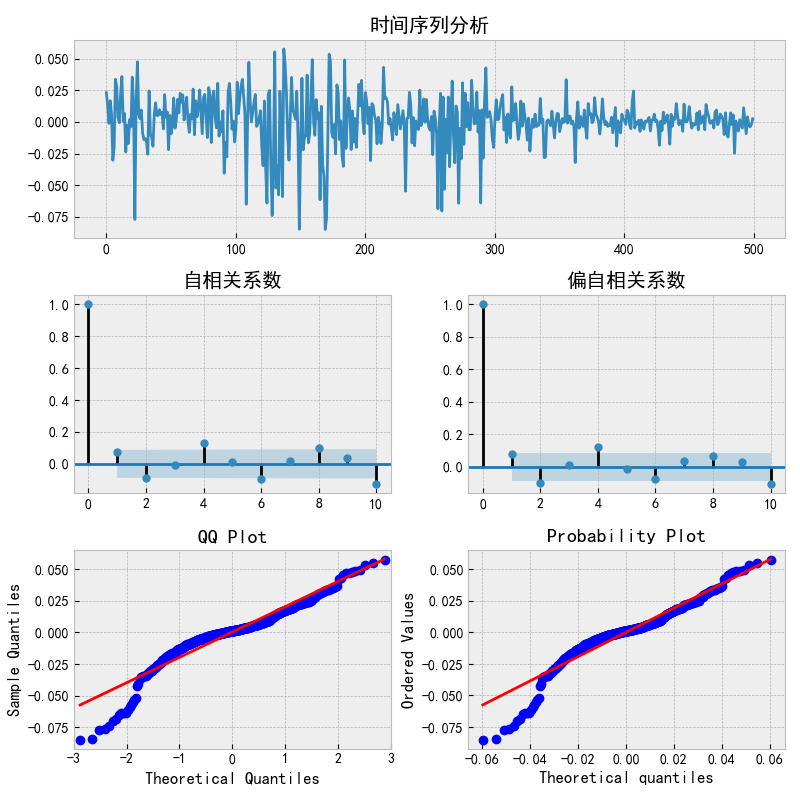

In [7]:
tsplot(y=lrets.sz.values,lags=10)

于是我们建立AR(4)模型，即均值方程

In [8]:
mdl= sm.tsa.ARMA(lrets.sz.values,(4,0)).fit()

### ARCH效应的检验

<IPython.core.display.Javascript object>


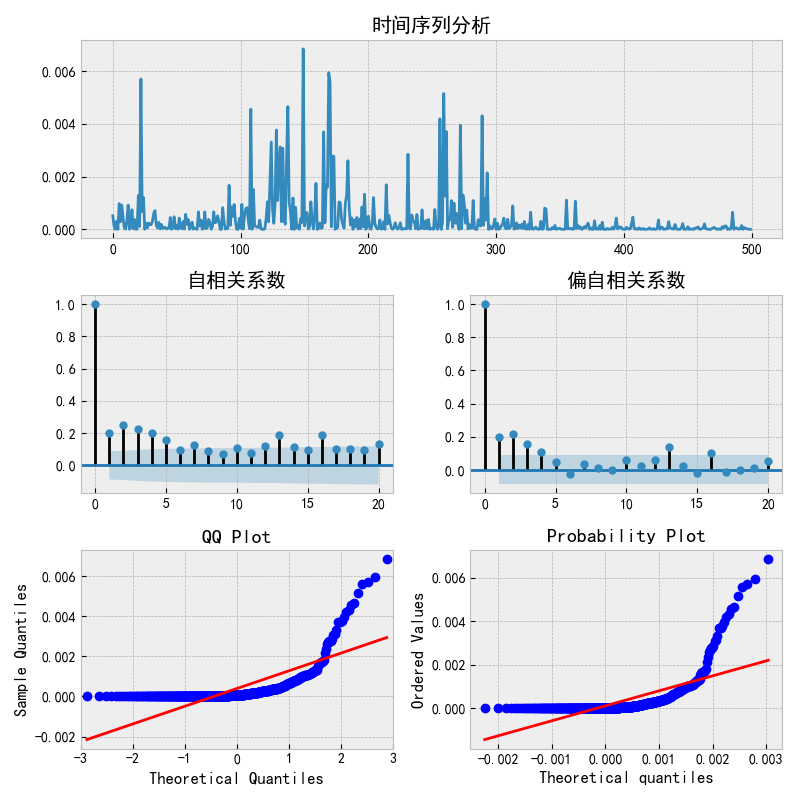

In [9]:
tsplot(mdl.resid**2,20)

残差平方序列$\{\varepsilon_t^2\}$具有相关性，符合异方差的假设，因此序列具有ARCH效应。
### ARCH模型的建立
首先讲讲ARCH模型的阶次，可以用$\{\varepsilon_t^2\}$序列的偏自相关函数PACF来确定：

根据我们之前的分析，可以粗略选择均值模型为AR(4)模型，波动率模型选择ARCH(4)模型

In [10]:
data=lrets.sz
train=data[:-10]
test=data[-10:]
am = arch.arch_model(train,mean='AR',lags=4,vol='ARCH',p=4) 
res = am.fit(show_warning=False)

Iteration:      1,   Func. Count:     12,   Neg. LLF: -1265.112100024574
Iteration:      2,   Func. Count:     31,   Neg. LLF: -1265.2638318633242
Iteration:      3,   Func. Count:     46,   Neg. LLF: -1268.0733200869408
Iteration:      4,   Func. Count:     65,   Neg. LLF: -1268.0736103407503
Iteration:      5,   Func. Count:     81,   Neg. LLF: -1268.0767464378464
Iteration:      6,   Func. Count:     98,   Neg. LLF: -1268.2044387632486
Iteration:      7,   Func. Count:    117,   Neg. LLF: -1268.2065458557736
Iteration:      8,   Func. Count:    131,   Neg. LLF: -1268.5084629984303
Iteration:      9,   Func. Count:    150,   Neg. LLF: -1268.6602495553905
Positive directional derivative for linesearch    (Exit mode 8)
            Current function value: -1268.660249621806
            Iterations: 13
            Function evaluations: 150
            Gradient evaluations: 9


In [11]:
res.summary(),res.params

(<class 'statsmodels.iolib.summary.Summary'>
 """
                            AR - ARCH Model Results                            
 Dep. Variable:                     sz   R-squared:                       0.008
 Mean Model:                        AR   Adj. R-squared:                 -0.001
 Vol Model:                       ARCH   Log-Likelihood:                1268.66
 Distribution:                  Normal   AIC:                          -2517.32
 Method:            Maximum Likelihood   BIC:                          -2475.46
                                         No. Observations:                  486
 Date:                Sun, Nov 04 2018   Df Residuals:                      476
 Time:                        23:11:44   Df Model:                           10
                                   Mean Model                                 
                  coef    std err          t      P>|t|       95.0% Conf. Int.
 -----------------------------------------------------------------------

<IPython.core.display.Javascript object>


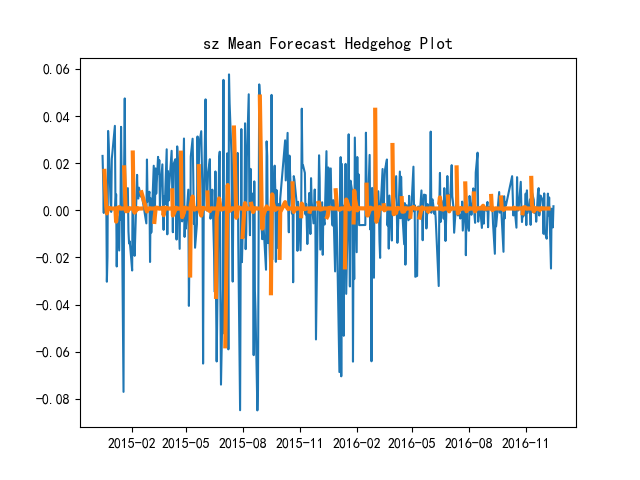

[]

In [12]:
res.hedgehog_plot(type='mean')
plt.plot()

# 广义自回归条件异方差模型 - GARCH（p，q）
简单地说，GARCH（p，q）是应用于时间序列方差的ARMA模型，即它具有自回归项和移动平均项。AR（p）模拟残差的方差（平方误差）或简单地模拟我们的时间序列平方。MA（q）部分模拟过程的方差。基本的$GARCH(m,n)$公式是：
$$ \large r_t=\mu+\varepsilon_t\\\large \sigma_t^2 = \omega + \sum_{i=1}^m\alpha_i\varepsilon_{t-i}^2+\sum_{j=1}^n\beta_j\sigma_{t-j}^2 \\ \large \varepsilon_t = \sigma_te_t,e_t\sim N(0,1) \\ $$
$ \sigma_t^2$为条件异方差。称$\{\varepsilon_{t}\}$服从GARCH(m,n)模型。仔细观察公式，发现与ARMA模型很相似。

<IPython.core.display.Javascript object>


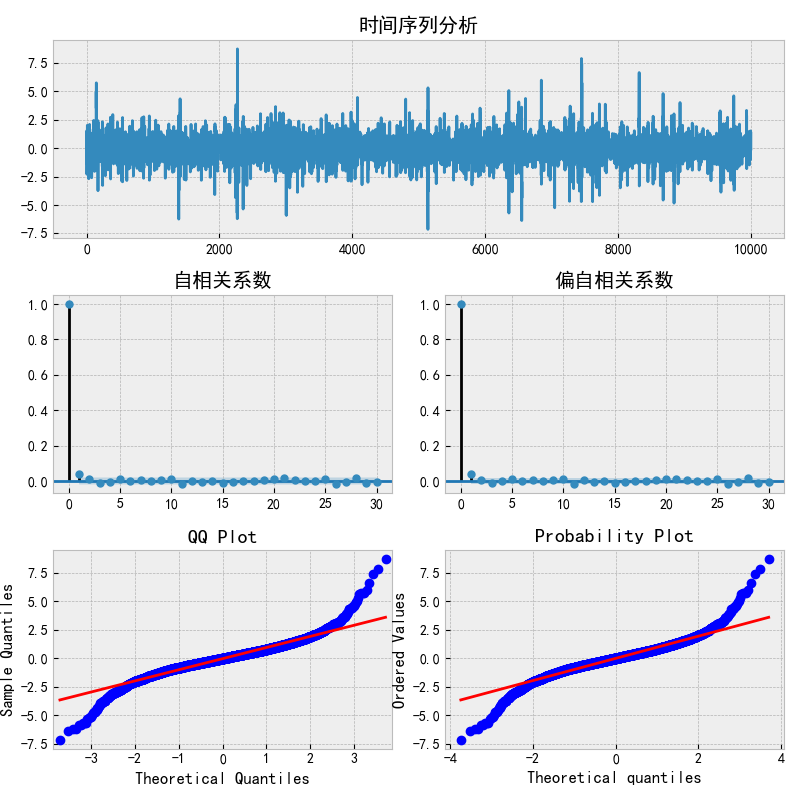

In [13]:
# 模拟一GARCH(1, 1)的序列
np.random.seed(2)
a0 = 0.2
a1 = 0.5
b1 = 0.3
n = 10000
w = np.random.normal(size=n)
eps = np.zeros_like(w)
sigsq = np.zeros_like(w)
for i in range(1, n):
    sigsq[i] = a0 + a1*(eps[i-1]**2) + b1*sigsq[i-1]
    eps[i] = w[i] * np.sqrt(sigsq[i])
tsplot(eps, lags=30)

<IPython.core.display.Javascript object>


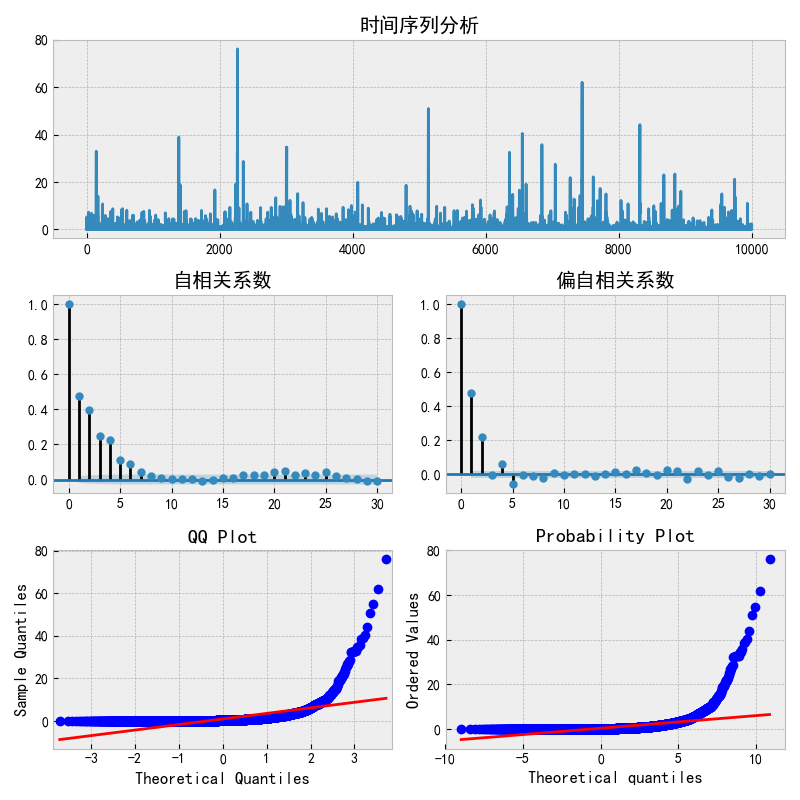

In [14]:
# 观察序列平方
tsplot(eps**2, lags=30)

In [15]:
# 适配一个GARCH(1, 1)模型
am = arch.arch_model(eps)
res = am.fit()
print(res.summary())

Iteration:      1,   Func. Count:      6,   Neg. LLF: 12544.984474387476
Iteration:      2,   Func. Count:     16,   Neg. LLF: 12544.063011049651
Iteration:      3,   Func. Count:     24,   Neg. LLF: 12506.451142689106
Iteration:      4,   Func. Count:     31,   Neg. LLF: 12330.96255485572
Iteration:      5,   Func. Count:     38,   Neg. LLF: 12311.793683614378
Iteration:      6,   Func. Count:     45,   Neg. LLF: 12255.302669133387
Iteration:      7,   Func. Count:     52,   Neg. LLF: 12248.817480103968
Iteration:      8,   Func. Count:     59,   Neg. LLF: 12244.22972565274
Iteration:      9,   Func. Count:     65,   Neg. LLF: 12239.566456812161
Iteration:     10,   Func. Count:     71,   Neg. LLF: 12238.592658753043
Iteration:     11,   Func. Count:     77,   Neg. LLF: 12237.312781730501
Iteration:     12,   Func. Count:     83,   Neg. LLF: 12237.303342894826
Iteration:     13,   Func. Count:     89,   Neg. LLF: 12237.303267319605
Optimization terminated successfully.    (Exit mode 0

上证指数收益率序列分析过程如下：
* 通过ARIMA（p，d，q）模型的组合迭代，以最适合我们的时间序列。 
* 根据具有最低AIC的ARIMA模型选择GARCH模型订单。
* 使GARCH（p，q）模型适合我们的时间序列。
* 检查模型残差和平方残差以进行自相关。

In [16]:
def _get_best_model(TS):
    best_aic = np.inf 
    best_order = None
    best_mdl = None
    pq_rng = range(5) # [0,1,2,3,4]
    d_rng = range(2) # [0,1]
    for i in pq_rng:
        for d in d_rng:
            for j in pq_rng:
                try:
                    tmp_mdl = smt.ARIMA(TS, order=(i,d,j)).fit(
                        method='mle', trend='nc'
                    )
                    tmp_aic = tmp_mdl.aic
                    if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_order = (i, d, j)
                        best_mdl = tmp_mdl
                except: continue
    print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))                    
    return best_aic, best_order, best_mdl
TS = lrets.sz
res_tup = _get_best_model(TS)

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ig

d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarni

aic: -2512.57192 | order: (3, 0, 2)


d:\env\pythonve\test36\lib\site-packages\statsmodels\base\model.py:488: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
d:\env\pythonve\test36\lib\site-packages\statsmodels\tsa\base\tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


aic: -2512.57192 | order: (3, 0, 2)

<IPython.core.display.Javascript object>


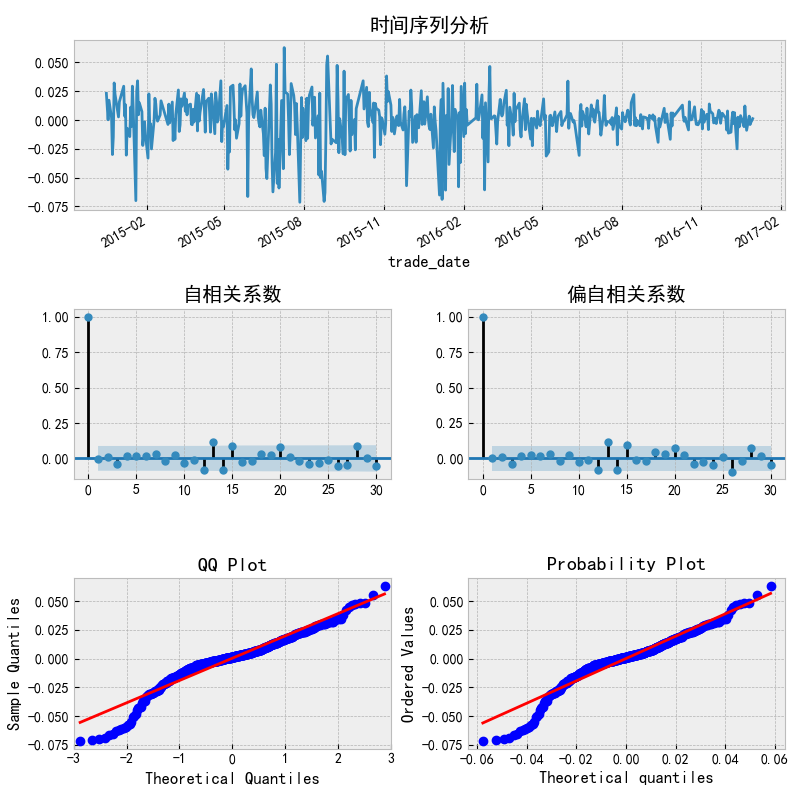

In [17]:
best_mdl=res_tup[2]
tsplot(best_mdl.resid)

残差序列看起来像白噪声。 

<IPython.core.display.Javascript object>


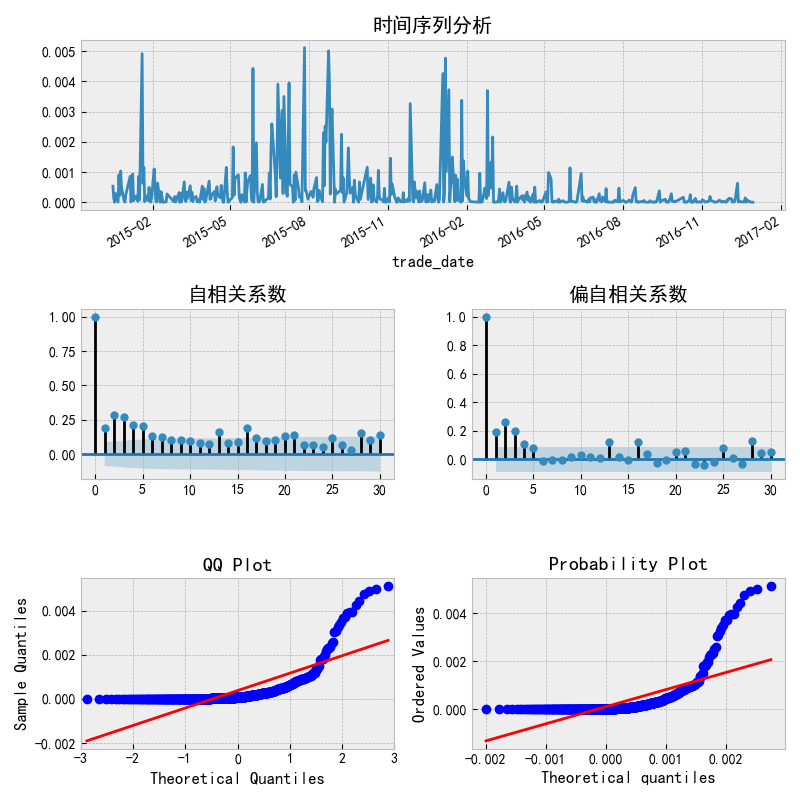

In [18]:
tsplot(best_mdl.resid**2)

残差平方显示自相关性。

In [19]:
am = arch.arch_model(TS, p=3, o=0, q=2, dist='StudentsT')
res = am.fit(update_freq=5, disp='off')
print(res.summary())

                        Constant Mean - GARCH Model Results                         
Dep. Variable:                           sz   R-squared:                      -0.002
Mean Model:                   Constant Mean   Adj. R-squared:                 -0.002
Vol Model:                            GARCH   Log-Likelihood:                1262.44
Distribution:      Standardized Student's t   AIC:                          -2508.89
Method:                  Maximum Likelihood   BIC:                          -2475.17
                                              No. Observations:                  500
Date:                      Sun, Nov 04 2018   Df Residuals:                      492
Time:                              23:11:57   Df Model:                            8
                                  Mean Model                                 
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
m

d:\env\pythonve\test36\lib\site-packages\arch\univariate\base.py:522: ConvergenceWarning: 
The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  ConvergenceWarning)


<IPython.core.display.Javascript object>


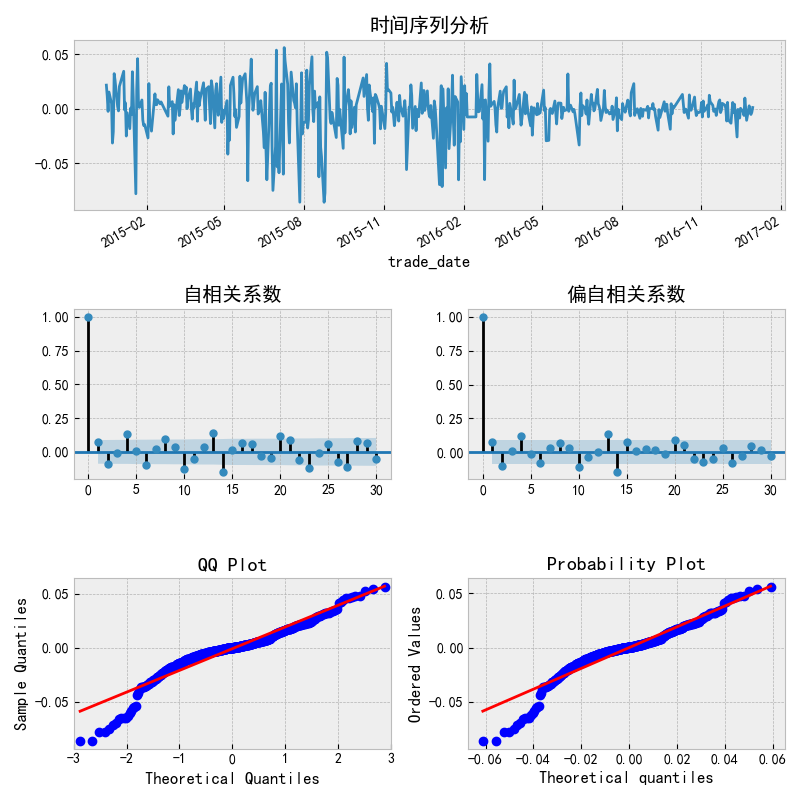

In [20]:
tsplot(res.resid)

<IPython.core.display.Javascript object>


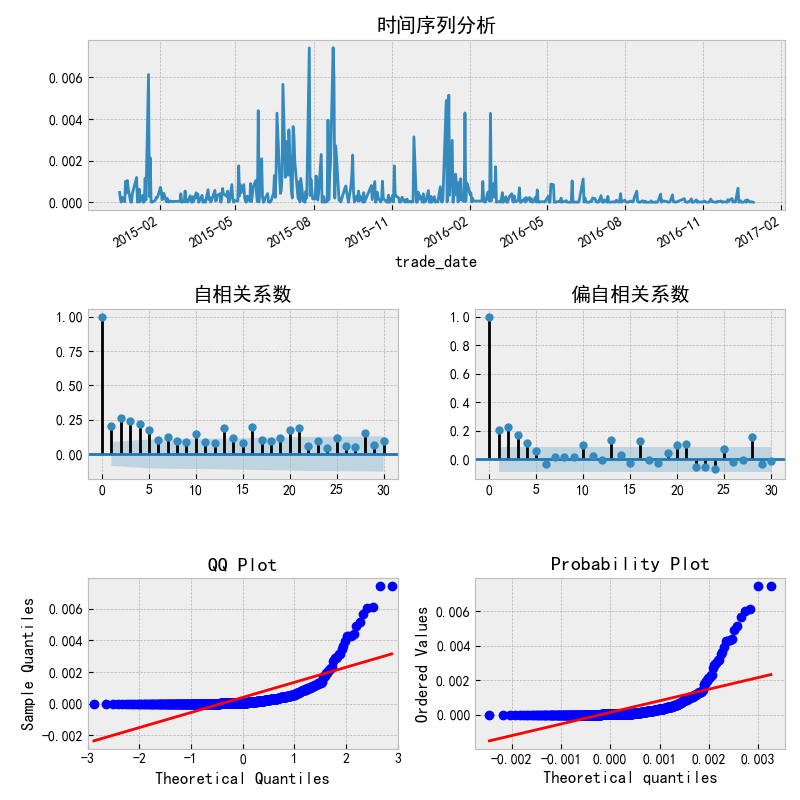

In [21]:
tsplot(res.resid**2)